In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils.image import resplit
import os

In [2]:
original_path = ['.', 'data', 'new_data']
new_path = ['.', 'data', 'relabeled_data']

In [6]:
resplit(original_path=original_path,
        original_label='LRNG',
        x=135, y=35, new_size=150,
        new_path=new_path,
        label_left='NG',
        label_right='NG')

### Data analysis: hkmold thermal image

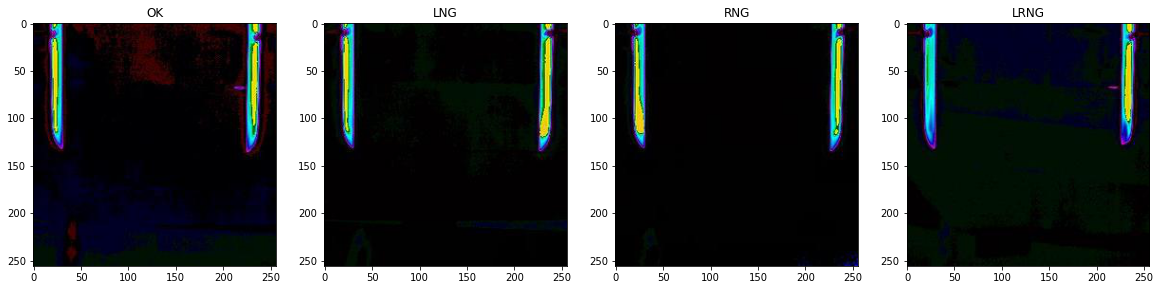

In [17]:
old_label = ['OK', 'LNG', 'RNG', 'LRNG']
imge_folder = 'new_data'
plt.figure(figsize=(20,5))
for i, label in enumerate(old_label):
    listfile = os.path.join(DATA_PATH, imge_folder, label)
    filename = os.listdir(listfile)[0]
    img = plt.imread(os.path.join(DATA_PATH, imge_folder, label, filename))
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.title(label)

In [11]:
def resplit(old_image, x, y, new_size):
    left_img = np.zeros(shape=(new_size, new_size, 3), dtype=old_image.dtype)
    right_img = np.zeros(shape=(new_size, new_size, 3), dtype=old_image.dtype)
    old_size = old_image.shape[0]
    x_start = (new_size - x) // 2
    y_start = (new_size - y) // 2
    
    left_img[x_start: x_start+x, y_start: y_start+y, :] = old_image[:x, :y, :]
    right_img[x_start: x_start+x, y_start: y_start+y, :] = np.flip(old_image[:x, old_size-y:, :], axis=1)
    
    return left_img, right_img

### Split and relabeled image: only OK or NG
### Original image ==> Split into 2 image: left and right  ==> vertical flip the right image
#### Original OK ===> 1 OK + 1 OK
#### Original LNG ===> 1 NG + 1 OK
#### Original RNG ===> 1 OK + 1 NG
#### Original LRNG ===> 1 NG + 1 NG

Text(0.5, 1.0, 'Original OK')

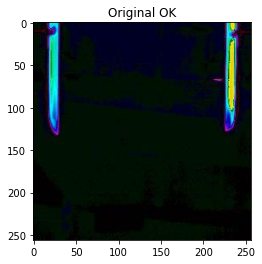

In [18]:
plt.imshow(img)
plt.title('Original OK')

Text(0.5, 1.0, 'OK (right side)')

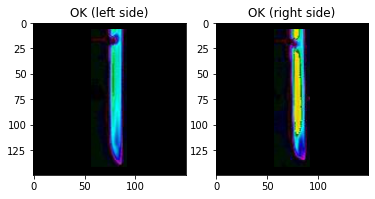

In [19]:
plt.subplot(121)
plt.imshow(left_img)
plt.title('OK (left side)')
plt.subplot(122)
plt.imshow(right_img)
plt.title('OK (right side)')

Text(0.5, 1.0, 'New dataset')

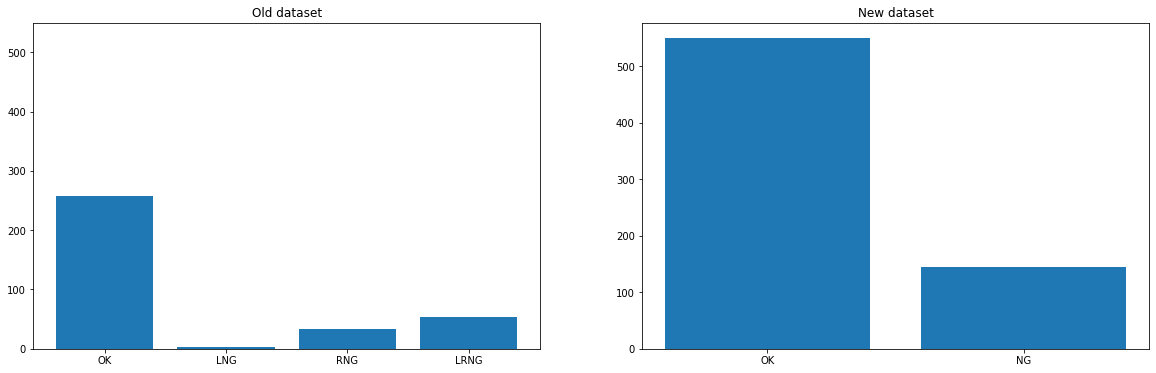

In [9]:
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.bar(x=['OK', 'LNG', 'RNG', 'LRNG'], height=[257, 3, 33, 54])
plt.ylim([0, 550])
plt.title('Old dataset')

plt.subplot(122)
plt.bar(x=['OK', 'NG'], height=[550, 144])
plt.title('New dataset')

### Reduce the imbalance
### Simplify the model

In [23]:
resplit(original_path=original_path,
        original_label='OK',
        x=140, y=40, new_size=150,
        new_path=new_path,
        label_left='OK',
        label_right='OK')

### Use rectangle image (size 150 x 50) instead of square image

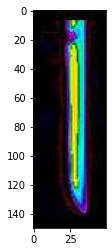

In [3]:
path = './data/rectangle_data/OK'
imgpath = os.listdir(path)[0]
img = plt.imread(os.path.join(path, imgpath))
plt.imshow(img)

In [1]:
import os
import numpy as np
import tensorflow as tf
from datetime import datetime, date
from utils.model import create_model
from utils.webservice import getsize_h5model, log_write
from utils.data import create_dataframe, ImageGenerator, get_sample, config_batch
from sklearn.model_selection import train_test_split

from configs.server import MODEL_PATH, LOG_FILE, FLAG, HIST, NEED_CONFIRM
from configs.image import DATA_PATH
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [24]:
image_folder = 'rectangle_data'
training_path = os.path.join(DATA_PATH, image_folder)
classes = [name for name in os.listdir(training_path)
               if os.path.isdir(os.path.join(training_path, name))]
num_classes = len(classes)
image_shape = (150, 50, 3)

In [25]:
image_dataframe = create_dataframe(training_path, classes)
image_dataframe.head(4)

,Filepath,Classes,Label
0,data\rectangle_data\NG\left_20191125091739_WEQ...,NG,0
1,data\rectangle_data\NG\left_20191125091923_WEQ...,NG,0
2,data\rectangle_data\NG\left_20191125092017_WEQ...,NG,0
3,data\rectangle_data\NG\left_20191125092137_WEQ...,NG,0


In [26]:
data_split = ['train', 'val']

In [27]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_frame, test_frame = train_test_split(image_dataframe, test_size=0.15, random_state=911)
dtframe = {'train': train_frame, 'val': test_frame}

generator = {x: image_generator.flow_from_dataframe(dataframe=dtframe[x], 
                                                    x_col='Filepath',
                                                    y_col='Classes',
                                                    target_size=(150, 50),
                                                    class_model='categorical',
                                                    shuffle = x == 'train',
                                                    batch_size=8)
            for x in data_split}

Found 589 validated image filenames belonging to 2 classes.
Found 105 validated image filenames belonging to 2 classes.


In [28]:
imgs, _ = next(generator['val'])

In [18]:
imgs.shape

(8, 150, 50, 3)

In [45]:
lr = 0.0007
def scheduler(epoch):
    if epoch < 7:
        return lr
    else:
        return lr * tf.math.exp(0.1 * (10 - epoch))

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [46]:
checkpoint_path = './tflog/simple_rectangle_v2.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
saving_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  monitor='val_accuracy',
                                                  save_best_only=True,
                                                  verbose=1)

In [47]:
model = create_model(model_name='Simple', 
                     n_outs=num_classes,
                     input_shape=image_shape,
                     learning_rate=lr,
                     pre_train=False)
history = model.fit(x=generator['train'],
                    validation_data=generator['val'],
                    validation_freq=1,
                    epochs=50,
                    verbose=1, 
                    callbacks=[lr_callback, saving_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 74 steps, validate for 14 steps
Epoch 1/50
73/74 [============================>.] - ETA: 0s - loss: 0.3010 - accuracy: 0.8520
Epoch 00001: val_accuracy improved from -inf to 0.19048, saving model to ./tflog/simple_rectangle_v2.h5
74/74 [==============================] - 3s 38ms/step - loss: 0.3007 - accuracy: 0.8506 - val_loss: 0.9859 - val_accuracy: 0.1905
Epoch 2/50
71/74 [===========================>..] - ETA: 0s - loss: 0.1852 - accuracy: 0.9257
Epoch 00002: val_accuracy did not improve from 0.19048
74/74 [==============================] - 2s 26ms/step - loss: 0.1893 - accuracy: 0.9219 - val_loss: 1.0372 - val_accuracy: 0.1905
Epoch 3/50
73/74 [============================>.] - ETA: 0s - loss: 0.1567 - accuracy: 0.9329
Epoch 00003: val_accuracy did not improve from 0.19048
74/74 [==============================] - 2s 26ms/step - loss: 0.1547 - accuracy: 0.9338 - val_loss: 1.2981 - val_accuracy: 0.1905
Epoch 4/50
73/74 [====

Epoch 28/50
72/74 [============================>.] - ETA: 0s - loss: 5.6195e-04 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.97143
74/74 [==============================] - 2s 26ms/step - loss: 5.6363e-04 - accuracy: 1.0000 - val_loss: 0.1652 - val_accuracy: 0.9524
Epoch 29/50
73/74 [============================>.] - ETA: 0s - loss: 5.3519e-04 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.97143
74/74 [==============================] - 2s 26ms/step - loss: 5.4196e-04 - accuracy: 1.0000 - val_loss: 0.1661 - val_accuracy: 0.9524
Epoch 30/50
71/74 [===========================>..] - ETA: 0s - loss: 5.3965e-04 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.97143
74/74 [==============================] - 2s 26ms/step - loss: 5.2216e-04 - accuracy: 1.0000 - val_loss: 0.1677 - val_accuracy: 0.9524
Epoch 31/50
72/74 [============================>.] - ETA: 0s - loss: 5.1673e-04 - accuracy: 1.0000
Epoch 00031: val_accuracy did not imp

In [48]:
model = tf.keras.models.load_model('./tflog/simple_rectangle_v2.h5')

In [49]:
model.evaluate(generator['val'])

  ...
    to  
  ['...']
14/14 [==============================] - 0s 14ms/step - loss: 0.1299 - accuracy: 0.9714


[0.12993507107187593, 0.9714286]

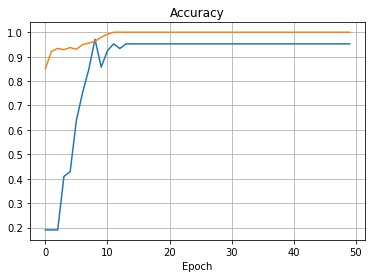

In [50]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.grid()

Text(0.5, 0, 'Epoch')

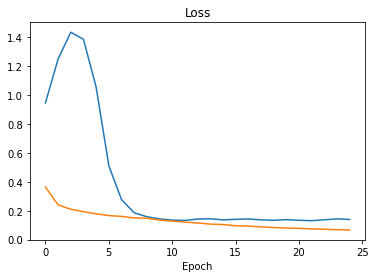

In [25]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')

### Comparison

In [41]:
from sklearn.metrics import confusion_matrix

In [51]:
true = test_frame['Label'].values.astype('int64')
pred = np.argmax(model.predict(generator['val']), axis=1)

# old_true = old_test_frame['Label'].values.astype('int64')
# old_pred = np.argmax(old_model.predict(old_generator['val']), axis=1)

In [53]:
confusion_matrix(y_true=true, y_pred=pred)

array([[19,  1],
       [ 2, 83]], dtype=int64)

In [21]:
confusion_matrix(y_true=old_true, y_pred=old_pred)

array([[ 2,  0,  0,  0],
       [ 0,  3,  1,  2],
       [ 0,  0, 41,  0],
       [ 0,  0,  0,  4]], dtype=int64)